In [1]:
import os
import random
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from tensorflow.keras import layers,regularizers,Sequential,backend,callbacks,optimizers,metrics,losses
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import tensorflow.keras.backend as TFK
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings('ignore')

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed=42)

In [3]:
# Function to map an filter out control group
def mapping_and_filter(train, train_targets, test):
#     non_ctl_idxs = train['cp_type']!='ctl_vehicle'
    X_train = train.reset_index(drop=True)
    Y_train = train_targets.reset_index(drop=True)
    X_test = test.reset_index(drop=True)
    cp_mask = X_train['cp_type'] == 0
    cp_type = {'trt_cp': 0, 'ctl_vehicle': 1}
    cp_dose = {'D1': 0, 'D2': 1}
    for df in [X_train, X_test]:
        df['cp_type'] = df['cp_type'].map(cp_type)
        df['cp_dose'] = df['cp_dose'].map(cp_dose)
    X_train.drop(['sig_id'], inplace = True, axis = 1)
    Y_train.drop(['sig_id'], inplace = True, axis = 1)
    X_test.drop(['sig_id'], inplace = True, axis = 1)
    return X_train, Y_train, X_test

In [4]:
# Function to scale our data
def scaling(train, test):
    features = train.columns[2:]
    scaler = RobustScaler()
    scaler.fit(pd.concat([train[features], test[features]], axis = 0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    return train, test, features

In [5]:
def get_pca_transform(features_data, ):
    pca_t = PCA(n_components=406)
#     pca_t = PCA(0.95)
    pca_data = pca_t.fit_transform(features_data)
    return pca_data

In [6]:
# Import train data
train_features = pd.read_csv(r'E:/Faculta/Anul2/Sem1/DATM/Proiect/data/train_features.csv')
train_targets_scored = pd.read_csv(r'E:/Faculta/Anul2/Sem1/DATM/Proiect/data/train_targets_scored.csv')

# Import test data
test_features = pd.read_csv(r'E:/Faculta/Anul2/Sem1/DATM/Proiect/data/test_features.csv')
submis = pd.read_csv('E:/Faculta/Anul2/Sem1/DATM/Proiect/data/sample_submission.csv')
print(train_features.shape, train_targets_scored.shape, test_features.shape)

(23814, 876) (23814, 207) (3982, 876)


In [7]:
df = pd.concat([train_features, train_targets_scored], axis=1, sort=False)

In [8]:
print('Number of NaNs in train dataset:', train_features.isna().values.sum())
print('Number of NaNs in test dataset:', test_features.isna().values.sum())

Number of NaNs in train dataset: 0
Number of NaNs in test dataset: 0


# Categoricals analysis

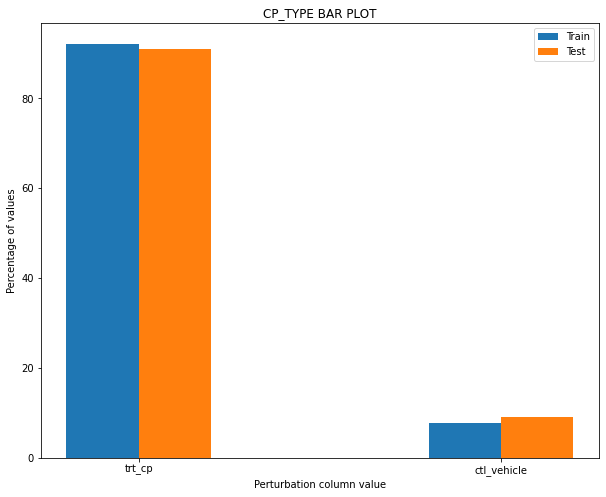

In [9]:
BAR_WIDTH = 0.2

percentage = train_features.cp_type.value_counts() / len(train_features) * 100
plt.figure(figsize=(10,8))
plt.bar(np.arange(len(percentage)), percentage.values, width=BAR_WIDTH, label='Train')

percentage = test_features.cp_type.value_counts() / len(test_features) * 100
plt.bar(np.arange(len(percentage)) + BAR_WIDTH, percentage.values, width=BAR_WIDTH, label='Test')

plt.xticks(np.arange(len(percentage)) + BAR_WIDTH / 2, percentage.index)
plt.legend()
plt.xlabel('Perturbation column value')
plt.ylabel('Percentage of values')
plt.title('CP_TYPE BAR PLOT')
plt.show()

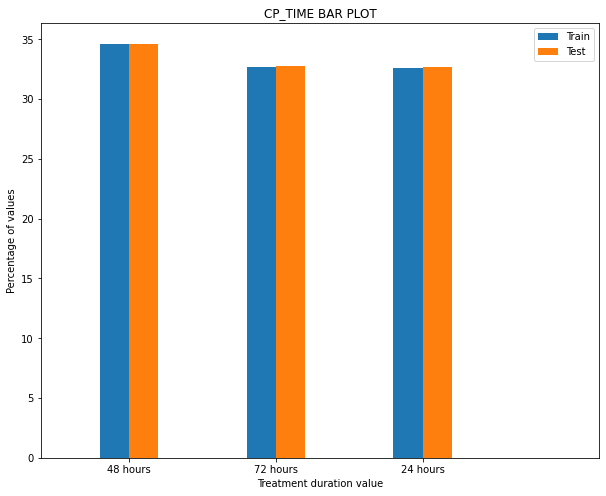

In [10]:
percentage = train_features.cp_time.value_counts() / len(train_features) * 100
plt.figure(figsize=(10,8))
plt.bar(np.arange(len(percentage)), percentage.values, width=BAR_WIDTH, label='Train')

percentage = test_features.cp_time.value_counts() / len(test_features) * 100
plt.bar(np.arange(len(percentage)) + BAR_WIDTH, percentage.values, width=BAR_WIDTH, label='Test')

plt.xticks(np.arange(len(percentage)) + BAR_WIDTH / 2, percentage.index.astype(str) + ' hours')
plt.xlim(-0.5, 3.3)
plt.legend()
plt.xlabel('Treatment duration value')
plt.ylabel('Percentage of values')
plt.title('CP_TIME BAR PLOT')
plt.show()

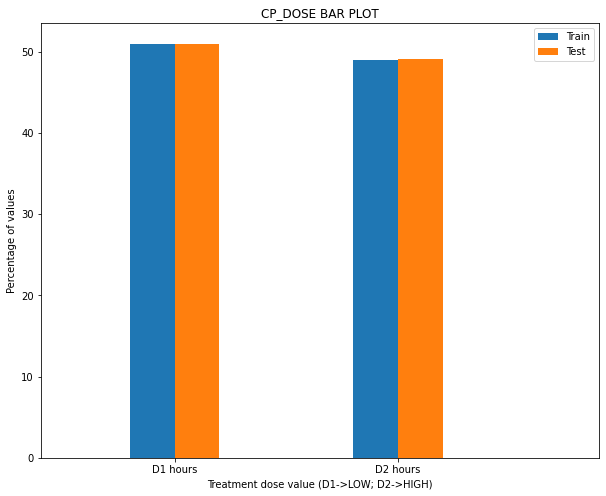

In [11]:
percentage = train_features.cp_dose.value_counts() / len(train_features) * 100
plt.figure(figsize=(10,8))
plt.bar(np.arange(len(percentage)), percentage.values, width=BAR_WIDTH, label='Train')

percentage = test_features.cp_dose.value_counts() / len(test_features) * 100
plt.bar(np.arange(len(percentage)) + BAR_WIDTH, percentage.values, width=BAR_WIDTH, label='Test')

plt.xticks(np.arange(len(percentage)) + BAR_WIDTH / 2, percentage.index.astype(str) + ' hours')
plt.xlim(-0.5, 2)
plt.legend()
plt.xlabel('Treatment dose value (D1->LOW; D2->HIGH)')
plt.ylabel('Percentage of values')
plt.title('CP_DOSE BAR PLOT')
plt.show()

# Genes analysis

In [12]:
gene_cols = [f'g-{i}' for i in range(772)]
train_features[gene_cols].values.min(), train_features[gene_cols].values.max()

(-10.0, 10.0)

In [13]:
gene_columns_sample = train_features[gene_cols].sample(9, axis=1)
gene_columns_sample.describe()

,g-538,g-213,g-361,g-417,g-582,g-78,g-515,g-351,g-641
count,23814.00000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,-0.14116,0.172382,0.097313,0.441745,0.055853,0.009940,-0.004424,-0.117395,-0.153958
std,0.95008,1.047997,1.035179,1.946993,1.206358,0.849408,0.997014,1.119672,1.011013
min,-10.00000,-3.638000,-10.000000,-5.212000,-8.498000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.63540,-0.267500,-0.504600,-0.471175,-0.541600,-0.484575,-0.520400,-0.538275,-0.526800
50%,-0.08860,0.000000,-0.014900,0.002350,-0.010650,-0.010400,-0.000300,0.036900,-0.019200
75%,0.39390,0.286300,0.517875,0.558025,0.589975,0.472375,0.512875,0.520300,0.439100
max,7.01600,10.000000,10.000000,10.000000,8.941000,5.416000,10.000000,7.034000,3.961000


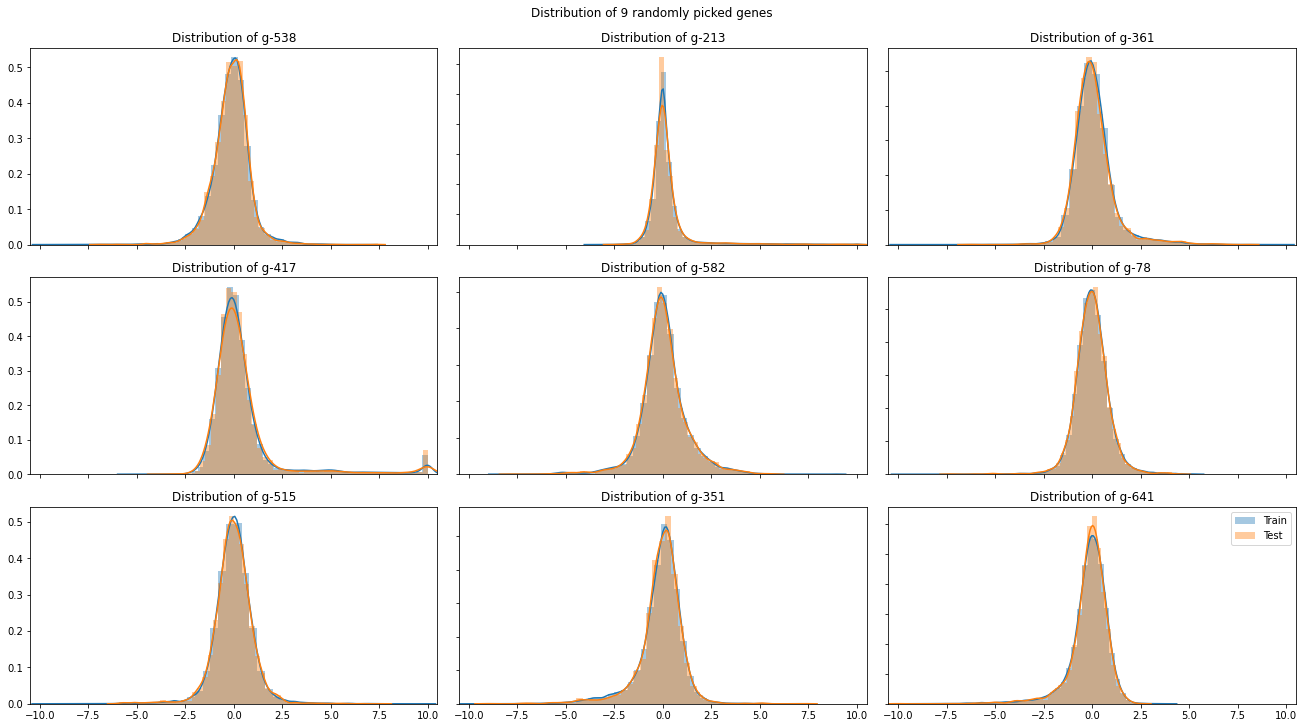

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(18, 10), constrained_layout=True)
plt.title("Distribution of 9 random picked genes")
for i, col in enumerate(gene_columns_sample):
    sns.distplot(train_features[col], ax=axs[i // 3, i % 3], label='Train')
    sns.distplot(test_features[col], ax=axs[i // 3, i % 3], label='Test')
    axs[i // 3, i % 3].set_title(f'Distribution of {col}')
for ax in axs.flat:
    ax.set(xlabel='', ylabel='')
    ax.set_xlim(-10.5, 10.5)
    ax.label_outer()
    ax.title.set_fontsize(12)
fig.suptitle('Distribution of 9 randomly picked genes')
plt.legend()
plt.show()

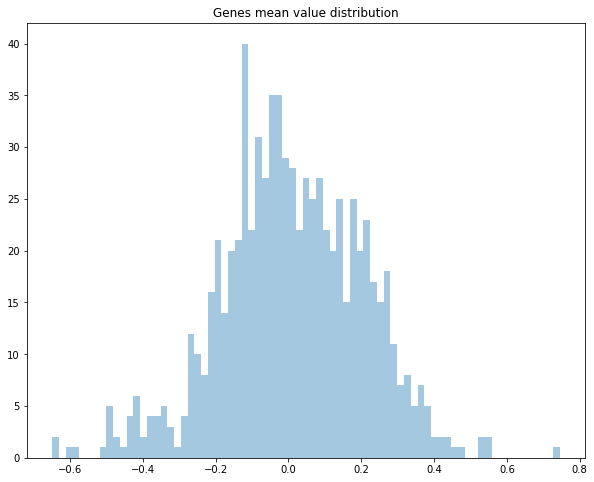

In [15]:
plt.figure(figsize=(10,8))
sns.distplot(train_features[gene_cols].mean(), kde=False, bins=75)
plt.title('Genes mean value distribution')
plt.show()

# Genes with highest/lowest means

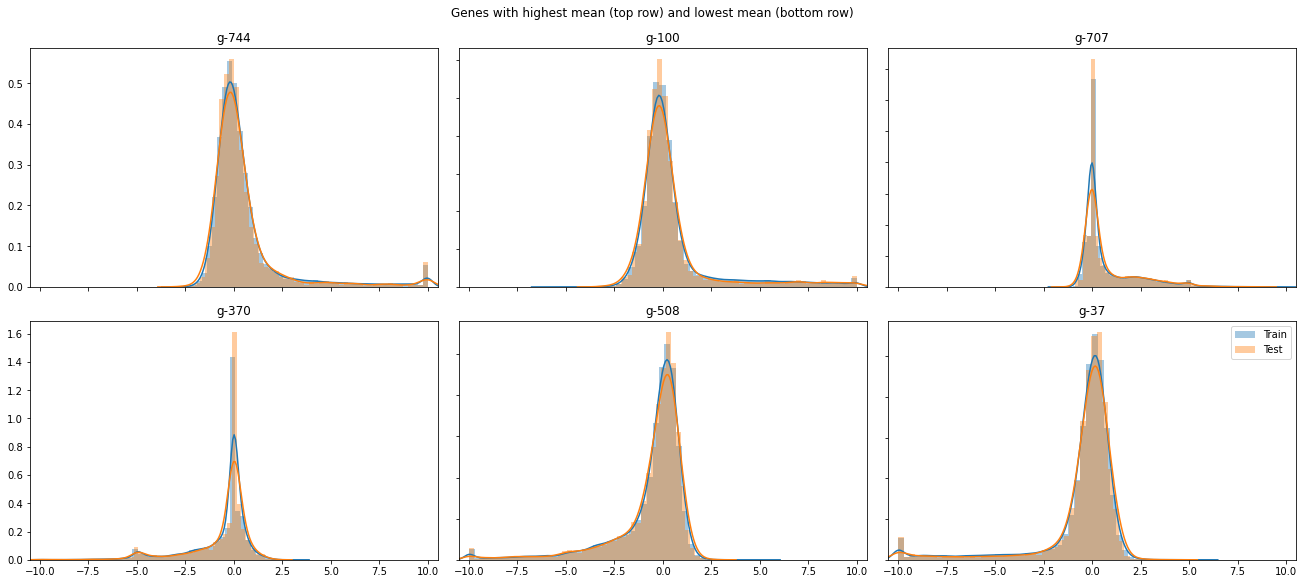

In [16]:
gene_cols_with_high_mean = np.argsort(train_features[gene_cols].mean())[-3:]
gene_cols_with_low_mean = np.argsort(train_features[gene_cols].mean())[:3]

fig, axs = plt.subplots(2, 3, figsize=(18, 8), constrained_layout=True)
for i, col_number in enumerate(gene_cols_with_high_mean):
    col_name = f'g-{col_number}'
    sns.distplot(train_features[col_name], ax=axs[0, i], label='Train')
    sns.distplot(test_features[col_name], ax=axs[0, i], label='Test')
    axs[0, i].set_title(col_name)
for i, col_number in enumerate(gene_cols_with_low_mean):
    col_name = f'g-{col_number}'
    sns.distplot(train_features[col_name], ax=axs[1, i], label='Train')
    sns.distplot(test_features[col_name], ax=axs[1, i], label='Test')
    axs[1, i].set_title(col_name)
for ax in axs.flat:
    ax.set(xlabel='', ylabel='')
    ax.set_xlim(-10.5, 10.5)
    ax.label_outer()
    ax.title.set_fontsize(12)
fig.suptitle('Genes with highest mean (top row) and lowest mean (bottom row)')
plt.legend()
plt.show()

# Features correlation

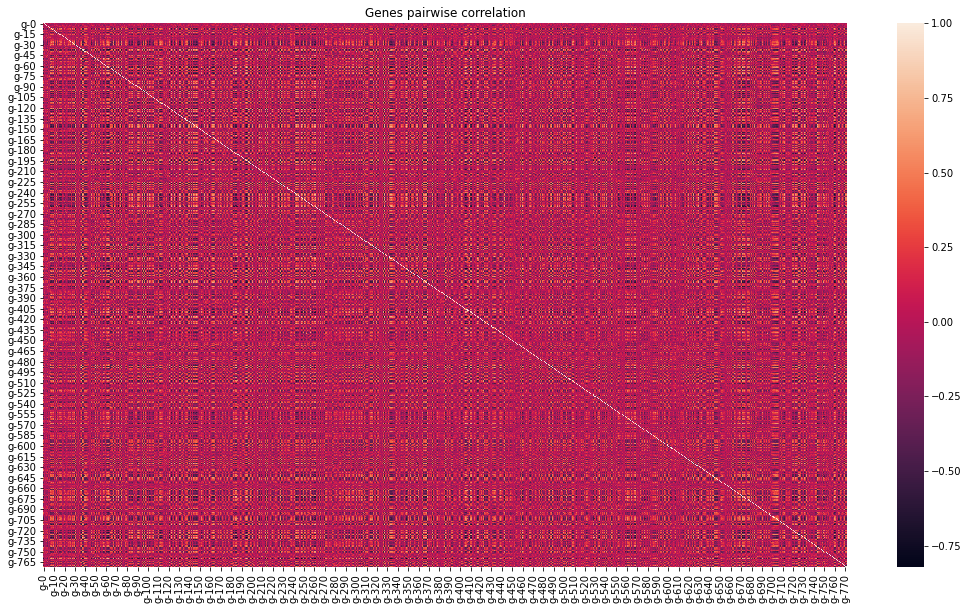

In [37]:
correlations = train_features[gene_cols].corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlations)
plt.title('Genes pairwise correlation')
plt.show()

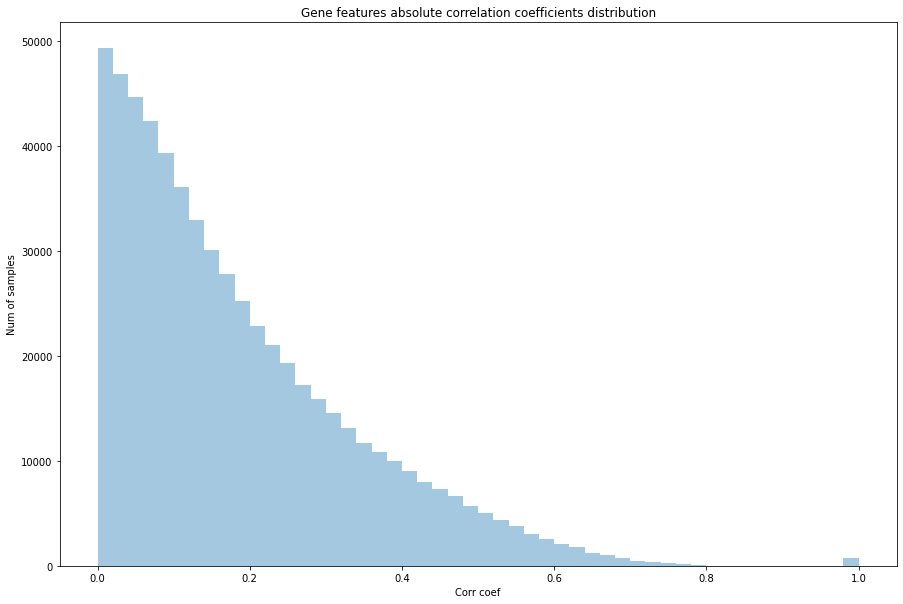

In [40]:
plt.figure(figsize=(15, 10))
sns.distplot(correlations.abs().values.flatten(), kde=False)
plt.title('Gene features absolute correlation coefficients distribution')
plt.xlabel('Corr coef')
plt.ylabel('Num of samples')
plt.show()

# Highest pairwise correlation genes 

Two features with the highest pairwise correlation in the train dataset: g-37, g-50
Correlation coefficient on train data: 0.9070612663690822
Correlation coefficient on test data: 0.9041249449444544


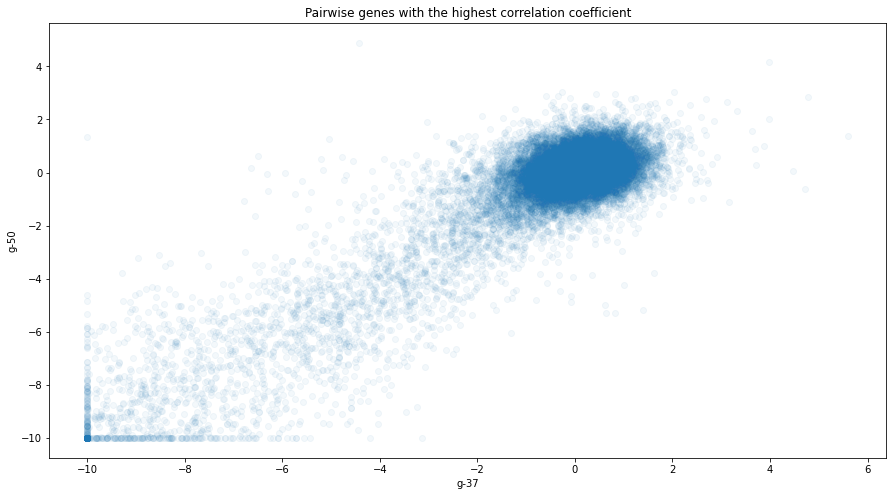

In [33]:
correlations_np = correlations.values
correlations_np[np.arange(len(gene_cols)), np.arange(len(gene_cols))] = np.NaN

max_corr = np.nanmax(correlations_np)
i, j = np.where(correlations_np == max_corr)[0]
i, j = f'g-{i}', f'g-{j}'
print(f'Two features with the highest pairwise correlation in the train dataset: {i}, {j}')
print(f'Correlation coefficient on train data:', max_corr)
print(f'Correlation coefficient on test data:', test_features[[i, j]].corr().values[0][1])
plt.figure(figsize=(15, 8))
plt.scatter(train_features[i], train_features[j], alpha=0.05)
plt.xlabel(i)
plt.ylabel(j)
plt.title('Pairwise genes with the highest correlation coefficient')
plt.show()

# Lowest pairwise correlation genes

Two features with the lowest pairwise correlation in the train dataset: g-228, g-349
Correlation coefficient on train data: -0.8202749561736778
Correlation coefficient on test data: -0.8364079437839882


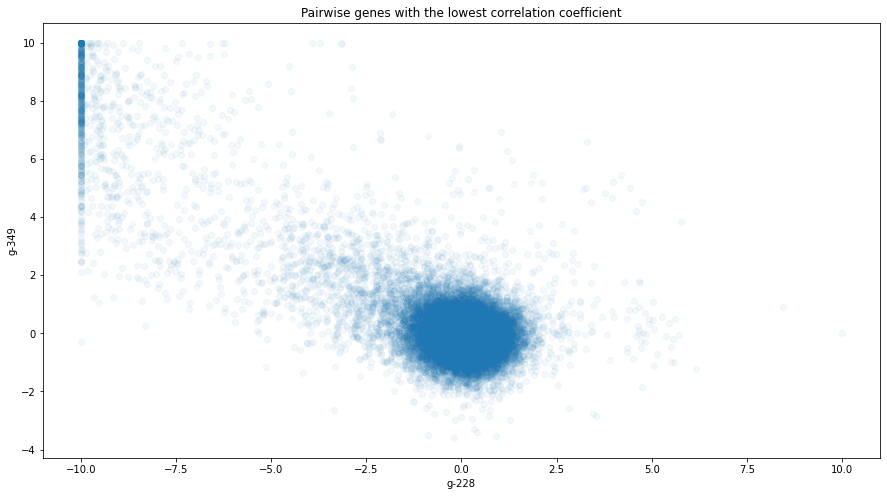

In [36]:
min_corr = np.nanmin(correlations_np)
i, j = np.where(correlations_np == min_corr)[0]
i, j = f'g-{i}', f'g-{j}'
print(f'Two features with the lowest pairwise correlation in the train dataset: {i}, {j}')
print(f'Correlation coefficient on train data:', min_corr)
print(f'Correlation coefficient on test data:', test_features[[i, j]].corr().values[0][1])
plt.figure(figsize=(15, 8))
plt.scatter(train_features[i], train_features[j], alpha=0.05)
plt.xlabel(i)
plt.ylabel(j)
plt.title('Pairwise genes with the lowest correlation coefficient')
plt.show()

# Targets analysis

In [17]:
targets = pd.read_csv('E:/Faculta/Anul2/Sem1/DATM/Proiect/data/train_targets_scored.csv')

In [18]:
target_cols = targets.columns[1:]
frequent_targets = (targets[target_cols].mean() * 100).sort_values()[-20:].index

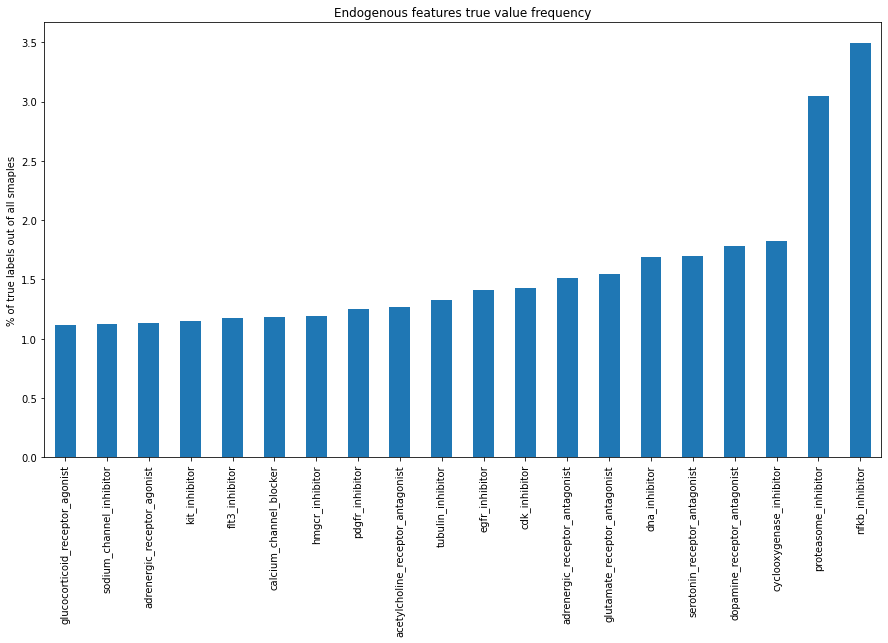

In [22]:
plt.figure(figsize=(15, 8))
(targets[frequent_targets].mean() * 100).sort_values().plot.bar()
plt.title('Endogenous features true value frequency')
plt.ylabel('% of true labels out of all smaples')
plt.show()

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

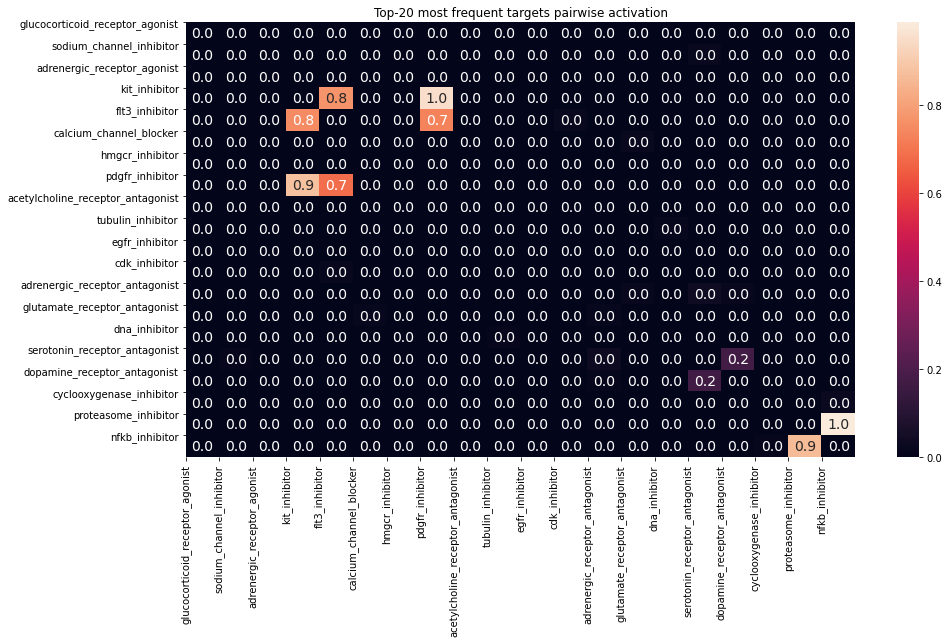

In [54]:
counts = np.zeros((len(frequent_targets), len(frequent_targets)))
for i, col1 in enumerate(frequent_targets):
    for j, col2 in enumerate(frequent_targets):
        if i != j:
            counts[i, j] = len(targets[(targets[col1] == 1) & (targets[col2] == 1)]) / len(targets[targets[col1] == 1]) 
            

            plt.figure(figsize=(12, 10))
plt.figure(figsize=(15, 8))
sns.heatmap(counts, annot=True, fmt=".1f", annot_kws={"size": 14})
plt.xticks(np.arange(len(frequent_targets)), frequent_targets, rotation=90)
plt.yticks(np.arange(len(frequent_targets)), frequent_targets, rotation=0)
plt.title('Top-20 most frequent targets pairwise activation')
plt.show()